# **Predicting Player's Engagement Based on Age**

##### Emma Chow, Yoobeen Hong, Samantha Kwong, Gabriel Moi

## **Introduction**

This data set was compiled by a research group at UBC studying how players interact with a Minecraft server. The goal of the study is to identify which types of players contribute to high volumes of data, indicating that they may be worth pursuing for recruitment. 

In this project, we explore whether a player's age can be used to predict their level of engagement, categorized as a low-hour, medium-hour, or high-hour player. By building a predictive model, we aim to better understand which players are more likely to interact with the game, and as such, are worth targeting for recruitment. 

#### Research Question

> Can player age accurately predict whether the player is a low-hour, medium-hour or high-hour player?

#### Describing the dataset

To achieve this, we used the original `players.csv` dataset and focused on each player’s **age** and their corresponding **total play-time** length to build the model. The `players.csv` file contains information about each player's experience level, subscription status, identity, and age. A summary of th: 

| Name of variable | Type | Description |
|----------------- | ---- | ----------- |
| experience | chr | The self-reported level of experience of each player |
| subscribe | lgl | The player's subscription status to a game-related newsletter |
| hashedEmail | chr | The hashed email addresses of each player to identify players without revealing their contact information| 
| played_hours | dbl | The numbers of hours players were playing the game |
| name | chr | The names of each of the players | 
| gender | chr | The gender that each player identifies by | 
| Age | dbl | The age of each player in years |

## **Method**

In [2]:
#Loading the libraries
library(tidyverse)
library(tidymodels)
library(dplyr)
library(RColorBrewer)
set.seed(42)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

#### **1. Data processing and preliminary visualisations**

Before starting the analysis, we cleaned and wrangled the dataset so that it is suitable for use. First, we read in the dataset using a URL. 

In [3]:
players_url <- read_csv("https://raw.githubusercontent.com/emma-chow/DSCI-Final-Project/70bbf2c6fcb0a1fd395c3b650eb82c00067f8953/players.csv")
head(players_url)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


To tidy the dataset, we identified whether there are missing values that need to be removed so that no error messages are returned when finding summary statistics. 

In [4]:
players_missing <- players_url |> 
    sapply(function(x) sum(is.na(x)))
players_missing

experience    subscribe  hashedEmail played_hours         name       gender 
           0            0            0            0            0            0 
         Age 
           2

As shown above, there are very little missing values in the dataset, in the variable "Age". So, the missing observations can be removed without biasing the data. 

In [5]:
players_data <- players_url |>
    drop_na()
glimpse(players_data)

Rows: 194
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 17, 22, 23, 17, 25, 22, 17…


Then, the variables used in the analysis were selected to create a separate dataframe. 

In [6]:
players <- players_data |>
select(Age, played_hours) 
head(players)

Age,played_hours
<dbl>,<dbl>
9,30.3
17,3.8
17,0.0
21,0.7
21,0.1
17,0.0


In order to determine the engagement level of the players, the played hours variable was categorised. The split of low, medium and high hours were decided using data from Statista (U.S. Adults Weekly Gaming Hours by Age 2024 | Statista, 2024). According to this source, the majority of people played between 1-15 hours. 

In [7]:
players_engagement <- players |>
mutate(engagement_level = factor((played_hours > 15) + (played_hours > 1), 
    levels = c(0, 1, 2), 
    labels = c("Low", "Medium", "High"))) 
head(players_engagement)

Age,played_hours,engagement_level
<dbl>,<dbl>,<fct>
9,30.3,High
17,3.8,Medium
17,0.0,Low
21,0.7,Low
21,0.1,Low
17,0.0,Low


Then, the data was split 70/30 into training and testing data. 

In [8]:
set.seed(1)
players_split <- initial_split(players_engagement, prop = 0.70, strata = engagement_level)  
players_train <- training(players_split)
players_test <- testing(players_split)

head(players_train)
head(players_test)

Age,played_hours,engagement_level
<dbl>,<dbl>,<fct>
9,30.3,High
21,0.7,Low
21,0.0,Low
17,0.0,Low
22,0.0,Low
17,0.0,Low


Age,played_hours,engagement_level
<dbl>,<dbl>,<fct>
17,0.0,Low
21,0.1,Low
17,0.0,Low
19,0.0,Low
17,0.1,Low
22,0.0,Low


Next, the proportions of each class in engagement_level was found in order to determine the number of observations in each class. This will be useful for evaluating the usefulness of the classifier later on. Below, the table shows that in both the training and testing set, low engagement levels is the majority class. 

In [9]:
players_train_proportions <- players_train |> 
    group_by(engagement_level) |>
    summarize(n = n()) |>
    mutate(percent = n/nrow(players_train)*100)
players_train_proportions

players_test_proportions <- players_test |> 
    group_by(engagement_level) |>
    summarize(n = n()) |>
    mutate(percent = n/nrow(players_test)*100)
players_test_proportions

engagement_level,n,percent
<fct>,<int>,<dbl>
Low,109,80.740741
Medium,16,11.851852
High,10,7.407407


engagement_level,n,percent
<fct>,<int>,<dbl>
Low,49,83.050847
Medium,8,13.559322
High,2,3.389831


The next step in processing the data is to compute the summary statistics for each of the variables. As the NAs have been removed, this is now possible. 
- Age: There is a 41 year age range in the data. The average age is 20 years old.
- played_hours: There is a wide range of played hours, 218.10 hours, with the lowest being 0.
- engagement_level: The majority class is low engagement level, while medium and high engagement levels have significantly less observations. 

In [10]:
players_summary <- players_train |>
    summary()
players_summary

      Age         played_hours    engagement_level
 Min.   : 8.00   Min.   :  0.00   Low   :109      
 1st Qu.:17.00   1st Qu.:  0.00   Medium: 16      
 Median :18.00   Median :  0.10   High  : 10      
 Mean   :20.59   Mean   :  6.21                   
 3rd Qu.:23.00   3rd Qu.:  0.65                   
 Max.   :49.00   Max.   :218.10                   

#### **2. Preliminary visualisations**

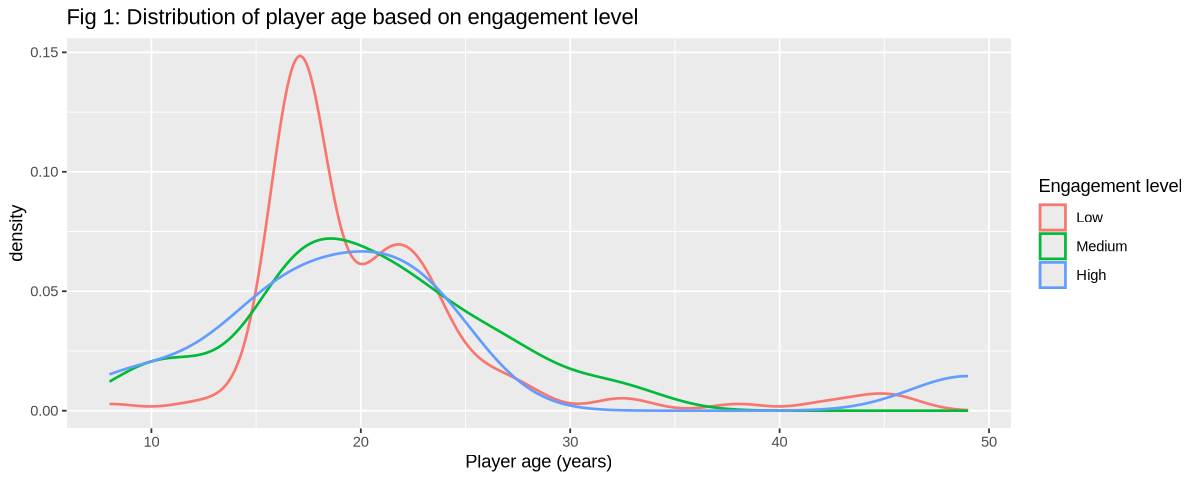

In [11]:
options(repr.plot.height = 4, repr.plot.width = 10)
plot_1 <- players_train |>
    ggplot(aes(x = Age, colour = engagement_level)) +
    geom_density(alpha = 0.2, linewidth = 0.75) + 
    labs(x = "Player age (years)", 
         colour = "Engagement level", 
         title = "Fig 1: Distribution of player age based on engagement level") +
    theme(element_text(size = 10))
plot_1

This plot was created to visualise the potential relationship between age (years) and engagement level. This plot suggests that there may be a weak relationship between player age and engagement level. Although there is significant overlap of the plots, indicating a weak or no relationship between the variables, the distribution of the medium and high plots (green and blue) is wider, suggesting that as the players are older or younger than the mean, they are more likely to engage in the game. Furthermore, the distribution of the low engagement level plot peaks at around age 18 and again at age 22, suggesting that the majority of players who have a low engagement level are around the median age. 

#### **3. Data analysis**

To begin data analysis, we created an initial recipe, where the predictor is age and the classifier is engagement level. When creating the model, an arbitrary number of neighbours was chosen because it is just used for creating the cross validation, which will later be able to pick the best number of neighbours to use. A workflow was also created and then fit to the training set. 

In [12]:
set.seed(2)
players_recipe <- recipe(engagement_level ~ Age, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    fit(data = players_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1851852
Best kernel: rectangular
Best k: 2

Next, we conducted a five-fold cross-validation in order to determine the optimal number of neighbours for this model. The dataframe k_vals was created in order to specify the range of k-values that we wanted to be tested. The range we chose to show in the plot was 1-20 because the plot plateaued after k = 6, indicating that the optimal number of neighbours is 6. 

In [13]:
set.seed(3)
players_vfold <- vfold_cv(players_train, v = 5, strata = engagement_level)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

→ A | warning: ✖ No observations were detected in `truth` for level: High.
               ℹ Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





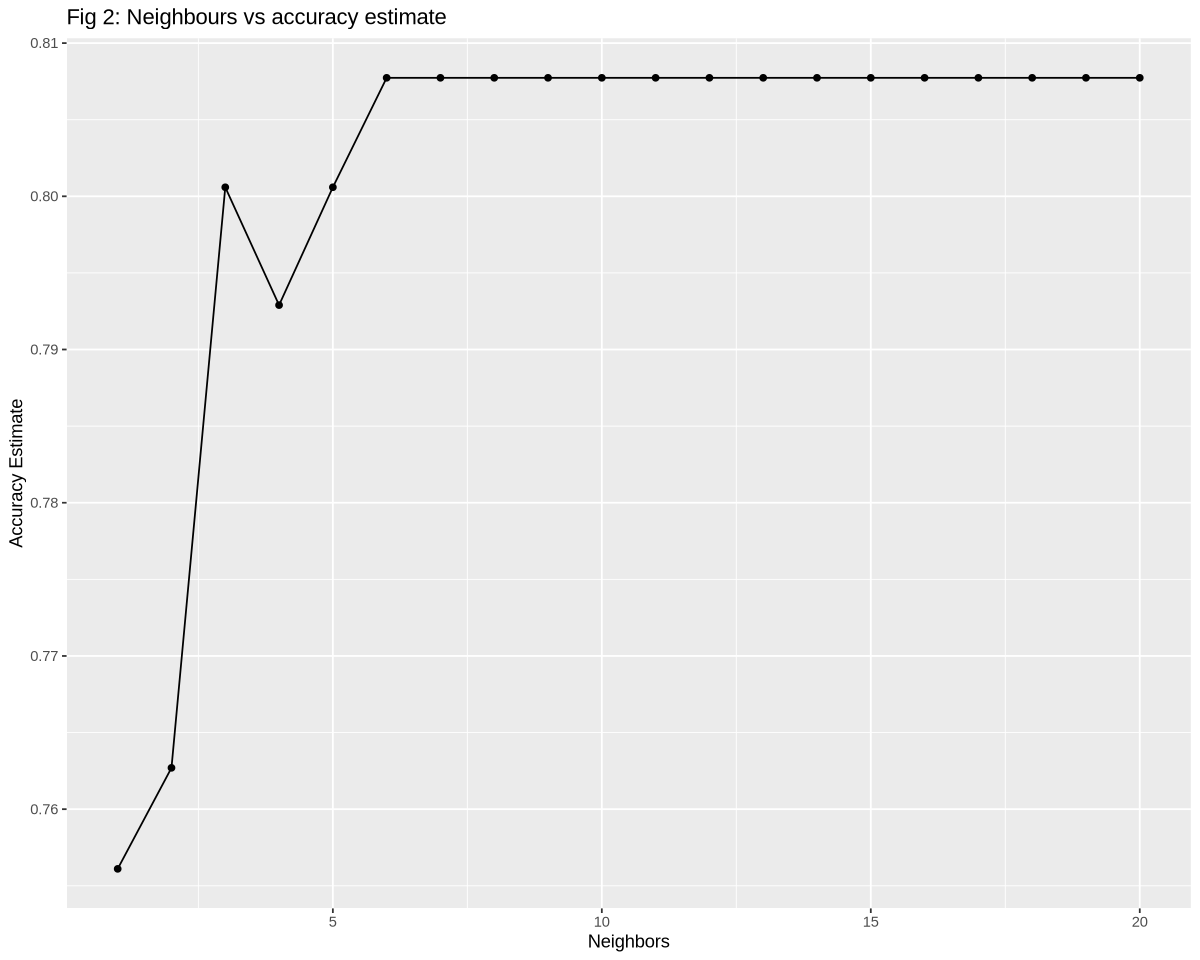

In [18]:
set.seed(4)
options(repr.plot.height = 8, repr.plot.width = 10)
k_acc <- players_fit |>
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(k_acc, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Fig 2: Neighbours vs accuracy estimate")
accuracy_vs_k

In [15]:
best_k <- k_acc |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
best_k

[1] 6

Then, the model was recreated but this time with the optimal k-value. A workflow was created and the model and recipe was fit back onto the training data. 

In [16]:
set.seed(3)

knn_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

players_fit_best <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec_best) |>
    fit(data = players_train)

players_fit_best

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(6,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1925926
Best kernel: rectangular
Best k: 6

Finally, the usefulness of the classifier was evaluated on the testing set. The accuracy, precision and recall were found. Additionally, a confusion matrix was created. 

In [19]:
players_test_predictions <- predict(players_fit_best, players_test) |>
    bind_cols(players_test) 

players_test_predictions |>
    metrics(truth = engagement_level, estimate = .pred_class) |>
    filter(.metric == "accuracy")

players_test_predictions |>
    precision(truth = engagement_level, estimate = .pred_class, event_level = "first") 

confusion <- players_test_predictions |>
    conf_mat(truth = engagement_level, estimate = .pred_class)
confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8305085


Warning message:
“While computing multiclass `precision()`, some levels had no predicted events
(i.e. `true_positive + false_positive = 0`).
Precision is undefined in this case, and those levels will be removed from the
averaged result.
Note that the following number of true events actually occurred for each
problematic event level:
'Medium': 8, 'High': 2”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,macro,0.8305085


          Truth
Prediction Low Medium High
    Low     49      8    2
    Medium   0      0    0
    High     0      0    0

## **Discussion**

#### **Results Summary**

In this project, our goal was to determine whether player age could be used to predict Minecraft engagement levels, as low-hour, medium-hour, and high-hour players. To model this, we used K-Nearest Neighbors (KNN) classifier on the `players.csv` dataset.

The classifier reached an accuracy of 83.05%, which exactly match the percentage of players in the majority class. This indicates that the model was simply predicted "low engagement" for every observation, without identifying any medium or high-hour players. So, although the accuracy seemed high, it wasn't a meaninigful indicator of predictive performance. 

Additionally, we calculated precision, which represents the average of the precision values for all classes. However, for the medium and high engagement classes, precision is actually undefined as the number of true positives plus false positives was zero. As a result, when computing overall precision, those undefined values were dropped, leading to a precision value equal to the accuracy.

This confirms that the classifier only predicted the majority class ("low engagement"), as shown in the confusion matrix. This is likely due to the large class imbalance, and further reinforces that age and engagement level have a very weak or no predictive relationship.
 
Overall, these findings suggest that the age alone is not a reliable predictor of player engagement. The imbalance in the class sizes likely made it difficult for the model to learn useful patterns distinguishing the different engagement levels.

#### **Reflection**

Interestingly, our initial visual analysis revealed a non-linear trend: players whose ages were farther from the average age of around 20, either younger or older, had a greater chance of being in the high-hour group. This suggested that both teen players and older "pros" could be more intensely engaged with the game than players close to the mean age.

These results partially aligned with our expectations. Since Minecraft is a game known to appeal to younger audiences, we anticipated that children and teens would be more engaged than older players. The model’s performance confirmed a general idea to a degree, though the model’s accuracy indicates that age alone is not a strong enough predictor to fully explain engagement behavior.

Despite these limitations, the findings offer useful insights. From a practical perspective, understanding age-related participation trends can help inform strategies. For example, servers or communities aiming to recruit active players might focus outreach efforts within younger age groups, particularly those between 9 - 17. Conversely, identifying less active age ranges could guide the design of new features or engagement strategies that aim to better involve those groups. 


## Reference

U.S. Adults weekly gaming hours by age 2024 | Statista. (2024). Statista. https://www.statista.com/statistics/202839/time-spent-playing-games-by-social-gamers-in-the-us/